In [65]:
# The following pytorch code is based on
# https://github.com/snowbbbb/code-for-Global-Convergence-of-Over-parameterized-Deep-Equilibrium-Models

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F  # Note: you have this import twice, so only one is needed.
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import cmath
from torch.utils.data import TensorDataset, DataLoader  # Removed unused imports: TensorDataset and random_split.
import torch.autograd as autograd
from torch.utils.data import Subset, ConcatDataset

# Set the visible GPU device if running on CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Optional: Random seed setup for reproducibility
SEED = 2
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)  # If using GPU
torch.backends.cudnn.deterministic = True  # Ensure deterministic results with CUDA
torch.backends.cudnn.benchmark = False  # Disable cudnn benchmarking for 

In [216]:
# Set dataset root directory
root_train = '/Users/lantruong/Dataset/CIFAR10/'

# Define transformation (Grayscale and ToTensor)
trainTransform = transforms.Compose([transforms.Grayscale(1), transforms.ToTensor()])

# Load the CIFAR-10 dataset
trainset_full = torchvision.datasets.CIFAR10(root=root_train, train=True, download=True, transform=trainTransform)
print("Full trainset length:", len(trainset_full))

# Get the indices for class 0 (airplane)
idx_class0 = [i for i, target in enumerate(trainset_full.targets) if target == 0]
trainset0 = Subset(trainset_full, idx_class0[:500])  # Select the first 500 samples of class 0

# Get the indices for class 1 (automobile)
idx_class1 = [i for i, target in enumerate(trainset_full.targets) if target == 1]
trainset1 = Subset(trainset_full, idx_class1[:500])  # Select the first 500 samples of class 1

# Concatenate both subsets into one dataset
trainset = ConcatDataset([trainset0, trainset1])
print("Concatenated trainset length:", len(trainset))

Files already downloaded and verified
Full trainset length: 50000
Concatenated trainset length: 1000


In [217]:
########################################################################
# Download and define the training set.

samplesize = 10000
netDepth = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
print(len(trainloader.dataset))
batchsize=1000
dataiter = iter(trainloader)
images,labels =next(dataiter)
images=torch.flatten(images,start_dim=1)
images = F.normalize(images, p=2, dim=1)
allLabel =torch.rand(1000)
train_ids = TensorDataset(images, allLabel)
trainloader = torch.utils.data.DataLoader(dataset=train_ids, batch_size=len(train_ids), shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output_size=1

1000


In [10]:
def FPiter(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta=1.0):
    #Anderson acceleration for fixed point iteration
    bsz, D = x0.shape
    X = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    X[:, 0], F[:, 0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:, 1], F[:, 1] = F[:, 0], f(F[:, 0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m + 1, m + 1, dtype=x0.dtype, device=x0.device)
    H[:, 0, 1:] = H[:, 1:, 0] = 1
    y = torch.zeros(bsz, m + 1, 1, dtype=x0.dtype, device=x0.device)
    y[:, 0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:, :n] - X[:, :n]
        H[:, 1:n + 1, 1:n + 1] = torch.bmm(G, G.transpose(1, 2)) + lam * torch.eye(n, dtype=x0.dtype, device=x0.device)[
            None]
        alpha = torch.linalg.solve(H[:, :n + 1, :n + 1],y[:, :n + 1])[:, 1:n + 1, 0]  # (bsz x n)

        X[:, k % m] = beta * (alpha[:, None] @ F[:, :n])[:, 0] + (1 - beta) * (alpha[:, None] @ X[:, :n])[:, 0]
        F[:, k % m] = f(X[:, k % m].view_as(x0)).view(bsz, -1)
        res.append((F[:, k % m] - X[:, k % m]).norm().item() / (1e-5 + F[:, k % m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:, k % m].view_as(x0), res

In [28]:
class Net(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   


    def forward(self, z, x):
        y = F.tanh(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [23]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z: self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z, x)

        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0, x)

        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y: autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

In [24]:
def get_jacobian(model, x):
    nc = x.size()[0]
    ny = x.size()[2]
    nx = x.size()[1]
    noutputs = 10
    x = x.reshape(nc * nx * ny)
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = model(x.reshape(noutputs, nc, nx, ny))
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data

In [25]:
def setup_and_train(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = Net(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot   

In [29]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001

width=3000
loss_plot3000=setup_and_train(epochs, lr, 3000, Wstd)

width=4000
loss_plot4000=setup_and_train(epochs, lr, 4000, Wstd)

width=5000
loss_plot5000=setup_and_train(epochs, lr, 5000, Wstd)



lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.68s | loss 708.62 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.65s | loss 301.23 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.60s | loss 228.23 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.68s | loss 214.72 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.63s | loss 211.81 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.83s | loss 189.79 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.73s | loss 189.41 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.83s | loss 189.03 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.80s | loss 188.65 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  8.78s | loss 188.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  8.80s | loss 187.90 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  8.93s | loss 174.27 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.83s | loss 174.01 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.91s | loss 173.75 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.78s | loss 173.50 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  8.78s | loss 173.24 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.81s | loss 163.40 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.80s | loss 163.20 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  8.53s | loss 163.01 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  8.59s | loss 162.81 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  8.70s | loss 162.62 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  8.68s | loss 162.43 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.77s | loss 154.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  8.94s | loss 154.63 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  8.82s | loss 154.47 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  8.87s | loss 154.32 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  8.86s | loss 154.16 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.79s | loss 147.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  8.92s | loss 147.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  8.71s | loss 147.66 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  8.89s | loss 147.53 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  8.82s | loss 147.40 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  8.72s | loss 147.27 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  8.92s | loss 142.06 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  9.03s | loss 141.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  8.93s | loss 141.84 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  9.01s | loss 141.74 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  8.94s | loss 141.63 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  8.95s | loss 137.20 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  9.01s | loss 137.10 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  8.76s | loss 137.01 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  8.71s | loss 136.92 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  8.81s | loss 136.82 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  8.81s | loss 136.73 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  8.72s | loss 132.93 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  8.73s | loss 132.85 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.87s | loss 132.77 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  8.98s | loss 132.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  8.88s | loss 132.61 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  8.68s | loss 129.32 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  8.78s | loss 129.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  8.74s | loss 129.18 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  8.79s | loss 129.11 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  8.76s | loss 129.04 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  8.76s | loss 128.97 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  8.91s | loss 126.11 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  8.80s | loss 126.05 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  8.91s | loss 125.99 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  8.79s | loss 125.93 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  8.81s | loss 125.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  8.79s | loss 123.35 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  8.74s | loss 123.30 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  8.80s | loss 123.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  8.80s | loss 123.19 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  8.82s | loss 123.14 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  8.83s | loss 123.08 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.81s | loss 120.86 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  8.90s | loss 120.81 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  8.78s | loss 120.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.95s | loss 120.72 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  8.76s | loss 120.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  8.74s | loss 118.70 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  8.76s | loss 118.66 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  8.75s | loss 118.61 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  9.20s | loss 118.57 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  8.80s | loss 118.53 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch 1069.09s | loss 118.49 
lambda_min tensor(0.0005+0.j, grad_

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  8.80s | loss 116.72 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  8.78s | loss 116.68 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  8.77s | loss 116.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  8.81s | loss 116.61 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  8.79s | loss 116.57 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  8.74s | loss 114.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  8.66s | loss 114.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  8.78s | loss 114.91 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  8.83s | loss 114.88 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  8.70s | loss 114.84 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8.84s | loss 114.81 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  8.99s | loss 113.37 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.97s | loss 113.34 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.76s | loss 113.31 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  8.76s | loss 113.28 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  8.83s | loss 113.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  8.90s | loss 111.94 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  8.90s | loss 111.91 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  8.92s | loss 111.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  8.88s | loss 111.86 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  8.75s | loss 111.83 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  8.83s | loss 111.80 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  8.89s | loss 110.60 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  8.80s | loss 110.58 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.73s | loss 110.55 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  8.74s | loss 110.53 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  8.74s | loss 110.50 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  8.88s | loss 109.40 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  8.78s | loss 109.38 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  8.70s | loss 109.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  8.92s | loss 109.33 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.69s | loss 109.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8.93s | loss 109.28 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  8.81s | loss 108.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  8.94s | loss 108.24 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  8.96s | loss 108.22 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  8.84s | loss 108.20 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  8.82s | loss 108.18 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1019 | time / epoch  8.80s | loss 107.23 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch  8.80s | loss 107.21 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  8.75s | loss 107.19 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  8.81s | loss 107.17 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  8.81s | loss 107.15 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  8.78s | loss 107.13 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1067 | time / epoch  8.81s | loss 106.27 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch  8.73s | loss 106.25 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  8.98s | loss 106.23 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  8.82s | loss 106.21 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  8.87s | loss 106.19 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  8.76s | loss 106.17 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1115 | time / epoch  8.80s | loss 105.37 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1116 | time / epoch  8.78s | loss 105.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  8.83s | loss 105.33 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.78s | loss 105.31 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  8.84s | loss 105.30 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.80s | loss 105.28 
lambda_min tensor(0.0004+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1163 | time / epoch  8.86s | loss 104.52 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1164 | time / epoch  8.71s | loss 104.50 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  8.97s | loss 104.49 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  8.80s | loss 104.47 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  8.77s | loss 104.45 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  8.82s | loss 104.44 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1211 | time / epoch  8.76s | loss 103.72 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1212 | time / epoch  8.74s | loss 103.71 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1213 | time / epoch  8.79s | loss 103.69 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / epoch  8.80s | loss 103.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.79s | loss 103.66 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.70s | loss 103.64 
lambda_min tensor(0.0005+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1259 | time / epoch  8.85s | loss 102.96 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1260 | time / epoch  8.75s | loss 102.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1261 | time / epoch  8.82s | loss 102.93 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / epoch  8.69s | loss 102.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  8.82s | loss 102.90 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  8.77s | loss 102.89 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1307 | time / epoch  8.79s | loss 102.25 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1308 | time / epoch  8.75s | loss 102.23 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1309 | time / epoch  8.79s | loss 102.22 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1310 | time / epoch  8.67s | loss 102.20 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1311 | time / epoch  8.73s | loss 102.19 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.78s | loss 102.17 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1355 | time / epoch  8.81s | loss 101.56 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1356 | time / epoch  8.70s | loss 101.55 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1357 | time / epoch  8.72s | loss 101.54 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1358 | time / epoch  8.80s | loss 101.52 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1359 | time / epoch  8.73s | loss 101.51 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.71s | loss 101.49 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1403 | time / epoch  8.71s | loss 100.91 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1404 | time / epoch  8.83s | loss 100.90 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1405 | time / epoch  8.73s | loss 100.88 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1406 | time / epoch  8.74s | loss 100.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1407 | time / epoch  8.78s | loss 100.86 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1408 | time / epoch  8.74s | loss 100.84 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1451 | time / epoch  8.76s | loss 100.29 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1452 | time / epoch  8.75s | loss 100.27 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1453 | time / epoch  8.72s | loss 100.26 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1454 | time / epoch  8.76s | loss 100.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1455 | time / epoch  8.82s | loss 100.24 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1456 | time / epoch  8.73s | loss 100.22 
lambda_min tensor(0.0006+0.j, g

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1500 | time / epoch  8.84s | loss 99.68 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1501 | time / epoch  9.10s | loss 99.66 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1502 | time / epoch  9.41s | loss 99.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1503 | time / epoch  9.03s | loss 99.64 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1504 | time / epoch  8.93s | loss 99.63 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1505 | time / epoch  

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1548 | time / epoch  8.81s | loss 99.10 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1549 | time / epoch  8.89s | loss 99.09 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1550 | time / epoch  8.75s | loss 99.08 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1551 | time / epoch  8.72s | loss 99.07 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1552 | time / epoch  8.83s | loss 99.05 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1553 | time / epoch  8.85s | loss 99.04 
lambda_min tensor(0.0005+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1597 | time / epoch  8.89s | loss 98.54 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1598 | time / epoch  9.07s | loss 98.53 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1599 | time / epoch  8.96s | loss 98.51 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1600 | time / epoch  8.91s | loss 98.50 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1601 | time / epoch 970.81s | loss 98.49 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1602 | time / epoch 

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1645 | time / epoch  8.84s | loss 98.00 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  8.76s | loss 97.99 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1647 | time / epoch  8.77s | loss 97.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1648 | time / epoch  8.76s | loss 97.97 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1649 | time / epoch  8.76s | loss 97.96 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1650 | time / epoch  8.92s | loss 97.95 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  8.73s | loss 97.48 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1695 | time / epoch  8.87s | loss 97.47 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1696 | time / epoch  8.78s | loss 97.46 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1697 | time / epoch  8.89s | loss 97.45 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1698 | time / epoch  8.82s | loss 97.44 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1699 | time / epoch  

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  8.85s | loss 96.98 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1743 | time / epoch  8.74s | loss 96.97 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1744 | time / epoch  8.75s | loss 96.96 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1745 | time / epoch  8.79s | loss 96.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1746 | time / epoch  8.76s | loss 96.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1747 | time / epoch  8.89s | loss 96.93 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  8.93s | loss 96.49 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1792 | time / epoch  8.85s | loss 96.48 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1793 | time / epoch  8.92s | loss 96.47 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1794 | time / epoch  8.88s | loss 96.46 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1795 | time / epoch  8.90s | loss 96.45 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1796 | time / epoch  

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1839 | time / epoch  8.80s | loss 96.02 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1840 | time / epoch  8.81s | loss 96.01 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1841 | time / epoch  8.73s | loss 96.00 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1842 | time / epoch  8.86s | loss 95.99 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1843 | time / epoch  8.80s | loss 95.98 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1844 | time / epoch  8.81s | loss 95.98 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1888 | time / epoch  8.79s | loss 95.56 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1889 | time / epoch  8.84s | loss 95.55 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1890 | time / epoch  8.91s | loss 95.54 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1891 | time / epoch 648.53s | loss 95.53 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1892 | time / epoch  8.93s | loss 95.52 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1893 | time / epoch 

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1936 | time / epoch  8.91s | loss 95.12 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1937 | time / epoch  8.85s | loss 95.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1938 | time / epoch  8.77s | loss 95.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1939 | time / epoch  8.81s | loss 95.09 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1940 | time / epoch  8.88s | loss 95.08 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1941 | time / epoch  8.87s | loss 95.07 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1985 | time / epoch  8.90s | loss 94.68 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1986 | time / epoch  8.83s | loss 94.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1987 | time / epoch  8.93s | loss 94.66 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1988 | time / epoch  8.94s | loss 94.66 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1989 | time / epoch  8.86s | loss 94.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1990 | time / epoch  

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  33 | time / epoch 18.15s | loss 154.68 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  34 | time / epoch 18.09s | loss 154.33 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  35 | time / epoch 18.03s | loss 153.99 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  36 | time / epoch 18.01s | loss 153.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  37 | time / epoch 17.92s | loss 153.32 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  38 | time / epoch 18.10s | loss 152.99 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  82 | time / epoch 18.04s | loss 141.67 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  83 | time / epoch 17.99s | loss 141.47 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  84 | time / epoch 18.01s | loss 141.28 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  85 | time / epoch 17.93s | loss 141.08 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  86 | time / epoch 18.10s | loss 140.89 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  87 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 130 | time / epoch 18.15s | loss 134.05 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 131 | time / epoch 18.09s | loss 133.93 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 132 | time / epoch 17.95s | loss 133.80 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 133 | time / epoch 17.99s | loss 133.68 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 134 | time / epoch 18.15s | loss 133.56 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 135 | time / epoch 18.06s | loss 133.44 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 179 | time / epoch 17.88s | loss 128.95 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 180 | time / epoch 17.82s | loss 128.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 181 | time / epoch 17.89s | loss 128.78 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 182 | time / epoch 18.16s | loss 128.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 183 | time / epoch 17.93s | loss 128.61 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 184 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 227 | time / epoch 18.14s | loss 125.35 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 228 | time / epoch 17.90s | loss 125.29 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 229 | time / epoch 18.03s | loss 125.22 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 230 | time / epoch 18.08s | loss 125.16 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 231 | time / epoch 18.67s | loss 125.09 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 232 | time / epoch 18.06s | loss 125.03 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 276 | time / epoch 17.91s | loss 122.49 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 277 | time / epoch 17.96s | loss 122.44 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 278 | time / epoch 17.96s | loss 122.39 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 279 | time / epoch 18.00s | loss 122.33 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 280 | time / epoch 18.14s | loss 122.28 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 281 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 324 | time / epoch 18.11s | loss 120.18 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 325 | time / epoch 18.17s | loss 120.13 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 326 | time / epoch 17.93s | loss 120.09 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 327 | time / epoch 18.02s | loss 120.05 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 328 | time / epoch 18.33s | loss 120.00 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 329 | time / epoch 18.08s | loss 119.96 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 373 | time / epoch 17.92s | loss 118.15 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 374 | time / epoch 17.89s | loss 118.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 375 | time / epoch 17.95s | loss 118.07 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 376 | time / epoch 18.12s | loss 118.03 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 377 | time / epoch 18.11s | loss 118.00 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 378 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 421 | time / epoch 18.06s | loss 116.39 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 422 | time / epoch 17.96s | loss 116.36 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 423 | time / epoch 18.26s | loss 116.33 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 424 | time / epoch 18.47s | loss 116.29 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 425 | time / epoch 18.06s | loss 116.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 426 | time / epoch 18.08s | loss 116.22 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 470 | time / epoch 17.99s | loss 114.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 471 | time / epoch 17.93s | loss 114.75 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 472 | time / epoch 17.96s | loss 114.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 473 | time / epoch 17.95s | loss 114.69 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 474 | time / epoch 17.86s | loss 114.66 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 475 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 518 | time / epoch 18.17s | loss 113.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 519 | time / epoch 18.16s | loss 113.32 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 520 | time / epoch 17.96s | loss 113.30 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 521 | time / epoch 18.21s | loss 113.27 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 522 | time / epoch 18.04s | loss 113.24 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 523 | time / epoch 18.09s | loss 113.21 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 567 | time / epoch 18.21s | loss 112.01 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 568 | time / epoch 18.25s | loss 111.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 569 | time / epoch 18.40s | loss 111.96 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 570 | time / epoch 18.17s | loss 111.93 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 571 | time / epoch 18.16s | loss 111.91 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 572 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 615 | time / epoch 17.95s | loss 110.80 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 616 | time / epoch 18.08s | loss 110.77 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 617 | time / epoch 17.86s | loss 110.75 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 618 | time / epoch 17.86s | loss 110.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 619 | time / epoch 17.94s | loss 110.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 620 | time / epoch 19.14s | loss 110.67 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 664 | time / epoch 19.29s | loss 109.64 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 665 | time / epoch 19.32s | loss 109.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 666 | time / epoch 19.11s | loss 109.60 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 667 | time / epoch 18.76s | loss 109.58 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 668 | time / epoch 18.36s | loss 109.55 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 669 | time / epoch 17

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 712 | time / epoch 18.06s | loss 108.59 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 713 | time / epoch 18.13s | loss 108.57 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 714 | time / epoch 18.06s | loss 108.55 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 715 | time / epoch 17.93s | loss 108.53 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 716 | time / epoch 17.99s | loss 108.51 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 717 | time / epoch 17.90s | loss 108.48 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 761 | time / epoch 17.90s | loss 107.58 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 762 | time / epoch 18.11s | loss 107.56 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 763 | time / epoch 17.96s | loss 107.54 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 764 | time / epoch 18.04s | loss 107.52 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 765 | time / epoch 17.98s | loss 107.50 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 766 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 809 | time / epoch 17.95s | loss 106.65 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 810 | time / epoch 17.99s | loss 106.63 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 811 | time / epoch 18.07s | loss 106.62 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 812 | time / epoch 18.23s | loss 106.60 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 813 | time / epoch 18.34s | loss 106.58 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 814 | time / epoch 18.05s | loss 106.56 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 858 | time / epoch 18.51s | loss 105.76 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 859 | time / epoch 18.01s | loss 105.74 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 860 | time / epoch 18.28s | loss 105.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 861 | time / epoch 18.02s | loss 105.70 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 862 | time / epoch 18.33s | loss 105.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 863 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 906 | time / epoch 17.96s | loss 104.93 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 907 | time / epoch 17.90s | loss 104.91 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 908 | time / epoch 17.86s | loss 104.89 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 909 | time / epoch 18.01s | loss 104.88 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 910 | time / epoch 18.06s | loss 104.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 911 | time / epoch 17.99s | loss 104.84 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 955 | time / epoch 18.14s | loss 104.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 956 | time / epoch 17.98s | loss 104.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 957 | time / epoch 17.87s | loss 104.09 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 958 | time / epoch 18.02s | loss 104.07 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 959 | time / epoch 18.21s | loss 104.06 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 960 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1003 | time / epoch 18.14s | loss 103.37 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1004 | time / epoch 18.03s | loss 103.35 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1005 | time / epoch 17.90s | loss 103.34 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1006 | time / epoch 17.91s | loss 103.32 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1007 | time / epoch 17.92s | loss 103.31 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1008 | time / epoch 18.10s | loss 103.29 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1051 | time / epoch 18.11s | loss 102.65 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1052 | time / epoch 18.24s | loss 102.64 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1053 | time / epoch 18.15s | loss 102.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1054 | time / epoch 18.32s | loss 102.61 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1055 | time / epoch 18.28s | loss 102.59 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1056 | time / epoch 17.86s | loss 102.58 
lambda_min tensor(0.0008+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1099 | time / epoch 17.93s | loss 101.96 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1100 | time / epoch 18.37s | loss 101.95 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1101 | time / epoch 17.96s | loss 101.94 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1102 | time / epoch 17.80s | loss 101.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1103 | time / epoch 17.89s | loss 101.91 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1104 | time / epoch 18.00s | loss 101.89 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1147 | time / epoch 17.96s | loss 101.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1148 | time / epoch 17.98s | loss 101.29 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1149 | time / epoch 18.04s | loss 101.28 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1150 | time / epoch 18.04s | loss 101.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1151 | time / epoch 18.05s | loss 101.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1152 | time / epoch 18.20s | loss 101.24 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1195 | time / epoch 17.86s | loss 100.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1196 | time / epoch 17.97s | loss 100.66 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1197 | time / epoch 18.01s | loss 100.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1198 | time / epoch 18.06s | loss 100.63 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1199 | time / epoch 17.81s | loss 100.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1200 | time / epoch 18.12s | loss 100.60 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1243 | time / epoch 17.87s | loss 100.06 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1244 | time / epoch 18.10s | loss 100.05 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1245 | time / epoch 18.31s | loss 100.03 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1246 | time / epoch 17.83s | loss 100.02 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1247 | time / epoch 18.15s | loss 100.01 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1248 | time / epoch 18.22s | loss 100.00 
lambda_min tensor(0.0006+0.j, g

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1292 | time / epoch 18.61s | loss 99.46 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1293 | time / epoch 18.29s | loss 99.44 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1294 | time / epoch 18.24s | loss 99.43 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1295 | time / epoch 18.35s | loss 99.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1296 | time / epoch 18.60s | loss 99.41 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1297 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1340 | time / epoch 18.06s | loss 98.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1341 | time / epoch 17.84s | loss 98.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1342 | time / epoch 18.16s | loss 98.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1343 | time / epoch 17.90s | loss 98.85 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1344 | time / epoch 18.54s | loss 98.84 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1345 | time / epoch 18.11s | loss 98.83 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1389 | time / epoch 18.27s | loss 98.33 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1390 | time / epoch 18.73s | loss 98.32 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1391 | time / epoch 18.22s | loss 98.30 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1392 | time / epoch 18.70s | loss 98.29 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1393 | time / epoch 18.30s | loss 98.28 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1394 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1437 | time / epoch 18.09s | loss 97.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1438 | time / epoch 17.98s | loss 97.78 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1439 | time / epoch 17.86s | loss 97.77 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1440 | time / epoch 18.13s | loss 97.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1441 | time / epoch 18.29s | loss 97.75 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1442 | time / epoch 18.10s | loss 97.74 
lambda_min tensor(0.0005+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1486 | time / epoch 18.31s | loss 97.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1487 | time / epoch 18.33s | loss 97.26 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1488 | time / epoch 18.30s | loss 97.25 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1489 | time / epoch 17.97s | loss 97.24 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1490 | time / epoch 18.06s | loss 97.22 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1491 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1534 | time / epoch 18.32s | loss 96.77 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1535 | time / epoch 17.97s | loss 96.76 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1536 | time / epoch 17.71s | loss 96.75 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1537 | time / epoch 17.99s | loss 96.73 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1538 | time / epoch 18.43s | loss 96.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1539 | time / epoch 17.85s | loss 96.71 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1583 | time / epoch 17.91s | loss 96.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1584 | time / epoch 17.43s | loss 96.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1585 | time / epoch 18.05s | loss 96.25 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1586 | time / epoch 18.11s | loss 96.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1587 | time / epoch 18.13s | loss 96.23 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1588 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1631 | time / epoch 17.90s | loss 95.80 
lambda_min tensor(0.0006-8.2682e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1632 | time / epoch 18.10s | loss 95.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1633 | time / epoch 18.28s | loss 95.78 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1634 | time / epoch 17.73s | loss 95.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1635 | time / epoch 18.42s | loss 95.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1636 | time / epoch 18.41s | loss 95.75 
lambda_min tensor(0.0005+0.j,

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1680 | time / epoch 17.85s | loss 95.33 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1681 | time / epoch 17.91s | loss 95.32 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1682 | time / epoch 17.97s | loss 95.31 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1683 | time / epoch 18.11s | loss 95.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1684 | time / epoch 18.27s | loss 95.29 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1685 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1728 | time / epoch 17.84s | loss 94.88 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1729 | time / epoch 18.15s | loss 94.87 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1730 | time / epoch 18.43s | loss 94.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1731 | time / epoch 18.06s | loss 94.85 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1732 | time / epoch 18.21s | loss 94.84 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1733 | time / epoch 18.00s | loss 94.83 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1777 | time / epoch 18.03s | loss 94.43 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1778 | time / epoch 17.80s | loss 94.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1779 | time / epoch 17.93s | loss 94.41 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1780 | time / epoch 18.05s | loss 94.40 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1781 | time / epoch 18.11s | loss 94.39 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1782 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1825 | time / epoch 17.90s | loss 94.00 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1826 | time / epoch 18.25s | loss 93.99 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1827 | time / epoch 18.19s | loss 93.98 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1828 | time / epoch 18.09s | loss 93.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1829 | time / epoch 18.10s | loss 93.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1830 | time / epoch 17.89s | loss 93.96 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1874 | time / epoch 18.18s | loss 93.58 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1875 | time / epoch 18.24s | loss 93.57 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1876 | time / epoch 18.06s | loss 93.56 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1877 | time / epoch 18.27s | loss 93.55 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1878 | time / epoch 18.11s | loss 93.54 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1879 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1922 | time / epoch 18.19s | loss 93.17 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1923 | time / epoch 18.20s | loss 93.16 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1924 | time / epoch 18.14s | loss 93.15 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1925 | time / epoch 18.12s | loss 93.14 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1926 | time / epoch 18.12s | loss 93.14 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1927 | time / epoch 18.12s | loss 93.13 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1971 | time / epoch 17.99s | loss 92.76 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1972 | time / epoch 18.06s | loss 92.75 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1973 | time / epoch 18.12s | loss 92.75 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1974 | time / epoch 18.14s | loss 92.74 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1975 | time / epoch 18.12s | loss 92.73 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1976 | time / epoch 1

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  19 | time / epoch 34.36s | loss 179.34 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  20 | time / epoch 34.48s | loss 178.46 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  21 | time / epoch 34.69s | loss 177.59 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  22 | time / epoch 35.35s | loss 176.73 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  23 | time / epoch 34.49s | loss 175.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  24 | time / epoch 34.39s | loss 175.06 
lambda_min tensor(0.0008+0.j, grad_fn

| end of epoch  67 | time / epoch 34.65s | loss 149.20 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  68 | time / epoch 34.39s | loss 148.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  69 | time / epoch 34.47s | loss 148.35 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  70 | time / epoch 34.65s | loss 147.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  71 | time / epoch 34.67s | loss 147.53 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  72 | time / epoch 34.58s | loss 147.13 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 116 | time / epoch 34.76s | loss 133.92 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 117 | time / epoch 34.45s | loss 133.70 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 118 | time / epoch 34.33s | loss 133.48 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 119 | time / epoch 34.53s | loss 133.26 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 120 | time / epoch 34.69s | loss 133.05 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 121 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 164 | time / epoch 34.46s | loss 125.75 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 165 | time / epoch 34.43s | loss 125.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 166 | time / epoch 34.47s | loss 125.49 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 167 | time / epoch 34.41s | loss 125.37 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 168 | time / epoch 34.73s | loss 125.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 169 | time / epoch 34.98s | loss 125.12 
lambda_min tensor(0.0006+0.j, grad_fn

| end of epoch 212 | time / epoch 34.76s | loss 120.73 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 213 | time / epoch 34.78s | loss 120.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 214 | time / epoch 34.84s | loss 120.56 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 215 | time / epoch 34.56s | loss 120.48 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 216 | time / epoch 34.67s | loss 120.39 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 217 | time / epoch 35.00s | loss 120.31 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 261 | time / epoch 34.32s | loss 117.22 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 262 | time / epoch 34.46s | loss 117.16 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 263 | time / epoch 34.49s | loss 117.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 264 | time / epoch 34.41s | loss 117.04 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 265 | time / epoch 34.55s | loss 116.98 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 266 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 309 | time / epoch 37.74s | loss 114.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 310 | time / epoch 9193.82s | loss 114.59 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 311 | time / epoch 40.40s | loss 114.55 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 312 | time / epoch 37.63s | loss 114.50 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 313 | time / epoch 37.47s | loss 114.45 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 314 | time / epoch 37.08s | loss 114.41 
lambda_min tensor(0.0007+0.j, grad_

| end of epoch 357 | time / epoch 34.18s | loss 112.57 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 358 | time / epoch 35.16s | loss 112.53 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 359 | time / epoch 34.40s | loss 112.49 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 360 | time / epoch 34.42s | loss 112.45 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 361 | time / epoch 34.34s | loss 112.41 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 362 | time / epoch 35.04s | loss 112.37 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 406 | time / epoch 34.24s | loss 110.79 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 407 | time / epoch 34.74s | loss 110.76 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 408 | time / epoch 34.50s | loss 110.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 409 | time / epoch 34.34s | loss 110.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 410 | time / epoch 34.30s | loss 110.66 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 411 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 454 | time / epoch 34.60s | loss 109.29 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 455 | time / epoch 34.11s | loss 109.26 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 456 | time / epoch 34.37s | loss 109.23 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 457 | time / epoch 34.30s | loss 109.20 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 458 | time / epoch 34.46s | loss 109.17 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 459 | time / epoch 34.37s | loss 109.14 
lambda_min tensor(0.0008+0.j, grad_fn

| end of epoch 502 | time / epoch 34.30s | loss 107.96 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 503 | time / epoch 34.56s | loss 107.94 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 504 | time / epoch 34.64s | loss 107.91 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 505 | time / epoch 34.41s | loss 107.89 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 506 | time / epoch 34.33s | loss 107.86 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 507 | time / epoch 34.27s | loss 107.83 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 551 | time / epoch 34.35s | loss 106.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 552 | time / epoch 34.34s | loss 106.73 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 553 | time / epoch 34.54s | loss 106.71 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 554 | time / epoch 34.25s | loss 106.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 555 | time / epoch 34.53s | loss 106.66 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 556 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 599 | time / epoch 34.53s | loss 105.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 600 | time / epoch 34.44s | loss 105.67 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 601 | time / epoch 34.59s | loss 105.65 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 602 | time / epoch 34.76s | loss 105.63 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 603 | time / epoch 34.43s | loss 105.60 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 604 | time / epoch 34.35s | loss 105.58 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 647 | time / epoch 34.32s | loss 104.72 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 648 | time / epoch 34.53s | loss 104.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 649 | time / epoch 34.36s | loss 104.68 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 650 | time / epoch 34.49s | loss 104.66 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 651 | time / epoch 34.35s | loss 104.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 652 | time / epoch 34.23s | loss 104.62 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 696 | time / epoch 34.24s | loss 103.81 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 697 | time / epoch 34.33s | loss 103.79 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 698 | time / epoch 34.43s | loss 103.77 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 699 | time / epoch 34.37s | loss 103.75 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 700 | time / epoch 34.46s | loss 103.74 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 701 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 744 | time / epoch 34.63s | loss 102.98 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 745 | time / epoch 34.43s | loss 102.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 746 | time / epoch 34.38s | loss 102.95 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 747 | time / epoch 34.39s | loss 102.93 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 748 | time / epoch 34.51s | loss 102.92 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 749 | time / epoch 34.58s | loss 102.90 
lambda_min tensor(0.0009+0.j, grad_fn

| end of epoch 792 | time / epoch 34.76s | loss 102.22 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 793 | time / epoch 34.58s | loss 102.20 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 794 | time / epoch 35.03s | loss 102.18 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 795 | time / epoch 34.56s | loss 102.17 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 796 | time / epoch 33.57s | loss 102.15 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 797 | time / epoch 34.53s | loss 102.14 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 841 | time / epoch 34.38s | loss 101.48 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 842 | time / epoch 35.23s | loss 101.47 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 843 | time / epoch 35.00s | loss 101.46 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 844 | time / epoch 34.19s | loss 101.44 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 845 | time / epoch 34.60s | loss 101.43 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 846 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 889 | time / epoch 34.41s | loss 100.81 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 890 | time / epoch 34.69s | loss 100.80 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 891 | time / epoch 35.59s | loss 100.78 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 892 | time / epoch 34.42s | loss 100.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 893 | time / epoch 34.56s | loss 100.76 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 894 | time / epoch 34.41s | loss 100.74 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 937 | time / epoch 34.43s | loss 100.17 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 938 | time / epoch 34.77s | loss 100.16 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 939 | time / epoch 34.09s | loss 100.15 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 940 | time / epoch 34.48s | loss 100.14 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 941 | time / epoch 34.43s | loss 100.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 942 | time / epoch 34.51s | loss 100.11 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 986 | time / epoch 34.80s | loss 99.56 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 987 | time / epoch 34.52s | loss 99.55 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 988 | time / epoch 34.72s | loss 99.53 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 989 | time / epoch 34.47s | loss 99.52 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 990 | time / epoch 34.49s | loss 99.51 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 991 | time / epoch 34.52s | loss 99.50 
lambda_min tensor(0.0007+0.j, grad_fn=<Sele

| end of epoch 1034 | time / epoch 34.76s | loss 98.99 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1035 | time / epoch 34.61s | loss 98.97 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1036 | time / epoch 35.02s | loss 98.96 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1037 | time / epoch 34.51s | loss 98.95 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1038 | time / epoch 34.54s | loss 98.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1039 | time / epoch 34.69s | loss 98.93 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1083 | time / epoch 35.35s | loss 98.43 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1084 | time / epoch 34.95s | loss 98.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1085 | time / epoch 34.69s | loss 98.40 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1086 | time / epoch 34.81s | loss 98.39 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1087 | time / epoch 34.57s | loss 98.38 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1088 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1131 | time / epoch 986.82s | loss 97.90 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1132 | time / epoch 34.24s | loss 97.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1133 | time / epoch 1098.56s | loss 97.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1134 | time / epoch 1037.07s | loss 97.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1135 | time / epoch 34.79s | loss 97.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1136 | time / epoch 1082.69s | loss 97.85 
lambda_min tensor(0.0007+0.j, 

| end of epoch 1179 | time / epoch 34.39s | loss 97.40 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1180 | time / epoch 34.61s | loss 97.39 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1181 | time / epoch 34.60s | loss 97.38 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1182 | time / epoch 34.66s | loss 97.37 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1183 | time / epoch 34.91s | loss 97.36 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1184 | time / epoch 34.12s | loss 97.35 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1228 | time / epoch 34.37s | loss 96.90 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1229 | time / epoch 34.36s | loss 96.89 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1230 | time / epoch 34.52s | loss 96.88 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1231 | time / epoch 34.50s | loss 96.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1232 | time / epoch 34.39s | loss 96.86 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1233 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1276 | time / epoch 34.24s | loss 96.43 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1277 | time / epoch 34.74s | loss 96.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1278 | time / epoch 34.43s | loss 96.42 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1279 | time / epoch 34.36s | loss 96.41 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1280 | time / epoch 34.29s | loss 96.40 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1281 | time / epoch 34.52s | loss 96.39 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 1324 | time / epoch 34.35s | loss 95.98 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1325 | time / epoch 34.57s | loss 95.97 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1326 | time / epoch 34.59s | loss 95.96 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1327 | time / epoch 34.44s | loss 95.95 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1328 | time / epoch 34.45s | loss 95.94 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1329 | time / epoch 34.38s | loss 95.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1373 | time / epoch 34.94s | loss 95.53 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1374 | time / epoch 6873.74s | loss 95.52 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1375 | time / epoch 4428.49s | loss 95.52 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1376 | time / epoch 34.61s | loss 95.51 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1377 | time / epoch 35.08s | loss 95.50 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1378 | time / epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1421 | time / epoch 34.76s | loss 95.11 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1422 | time / epoch 34.74s | loss 95.10 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1423 | time / epoch 34.85s | loss 95.09 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1424 | time / epoch 34.70s | loss 95.08 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1425 | time / epoch 34.73s | loss 95.07 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1426 | time / epoch 35.04s | loss 95.06 
lambda_min tensor(0.0006+0.j, grad_fn

| end of epoch 1469 | time / epoch 34.71s | loss 94.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1470 | time / epoch 34.70s | loss 94.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1471 | time / epoch 34.86s | loss 94.68 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1472 | time / epoch 34.43s | loss 94.67 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1473 | time / epoch 34.57s | loss 94.66 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1474 | time / epoch 34.86s | loss 94.65 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1518 | time / epoch 34.71s | loss 94.28 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1519 | time / epoch 34.36s | loss 94.28 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1520 | time / epoch 35.11s | loss 94.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1521 | time / epoch 34.68s | loss 94.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1522 | time / epoch 34.71s | loss 94.25 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1523 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1566 | time / epoch 34.84s | loss 93.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1567 | time / epoch 34.64s | loss 93.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1568 | time / epoch 34.58s | loss 93.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1569 | time / epoch 34.72s | loss 93.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1570 | time / epoch 34.76s | loss 93.86 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1571 | time / epoch 34.65s | loss 93.85 
lambda_min tensor(0.0008+0.j, grad_fn

| end of epoch 1614 | time / epoch 34.44s | loss 93.51 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1615 | time / epoch 34.78s | loss 93.50 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1616 | time / epoch 34.75s | loss 93.49 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1617 | time / epoch 35.03s | loss 93.49 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1618 | time / epoch 34.62s | loss 93.48 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1619 | time / epoch 34.86s | loss 93.47 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1663 | time / epoch 34.78s | loss 93.13 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1664 | time / epoch 34.76s | loss 93.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1665 | time / epoch 34.63s | loss 93.11 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1666 | time / epoch 34.72s | loss 93.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1667 | time / epoch 34.73s | loss 93.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1668 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1711 | time / epoch 34.78s | loss 92.76 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1712 | time / epoch 34.68s | loss 92.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1713 | time / epoch 34.72s | loss 92.75 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1714 | time / epoch 34.72s | loss 92.74 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1715 | time / epoch 34.93s | loss 92.73 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1716 | time / epoch 34.72s | loss 92.73 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 1759 | time / epoch 34.75s | loss 92.41 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1760 | time / epoch 35.11s | loss 92.40 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1761 | time / epoch 34.73s | loss 92.39 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1762 | time / epoch 35.21s | loss 92.38 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1763 | time / epoch 34.63s | loss 92.38 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1764 | time / epoch 34.69s | loss 92.37 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1808 | time / epoch 34.82s | loss 92.05 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1809 | time / epoch 34.71s | loss 92.04 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1810 | time / epoch 34.41s | loss 92.04 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1811 | time / epoch 35.08s | loss 92.03 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1812 | time / epoch 34.97s | loss 92.02 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1813 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1856 | time / epoch 35.08s | loss 91.71 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1857 | time / epoch 34.72s | loss 91.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1858 | time / epoch 35.02s | loss 91.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1859 | time / epoch 34.97s | loss 91.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1860 | time / epoch 34.52s | loss 91.68 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1861 | time / epoch 34.84s | loss 91.67 
lambda_min tensor(0.0006+0.j, grad_fn

| end of epoch 1904 | time / epoch 34.83s | loss 91.37 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1905 | time / epoch 34.72s | loss 91.37 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1906 | time / epoch 34.67s | loss 91.36 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1907 | time / epoch 34.68s | loss 91.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1908 | time / epoch 34.87s | loss 91.35 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1909 | time / epoch 34.59s | loss 91.34 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1953 | time / epoch 34.86s | loss 91.04 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1954 | time / epoch 34.77s | loss 91.03 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1955 | time / epoch 35.05s | loss 91.02 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1956 | time / epoch 34.84s | loss 91.02 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1957 | time / epoch 34.64s | loss 91.01 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1958 | time / epoch 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


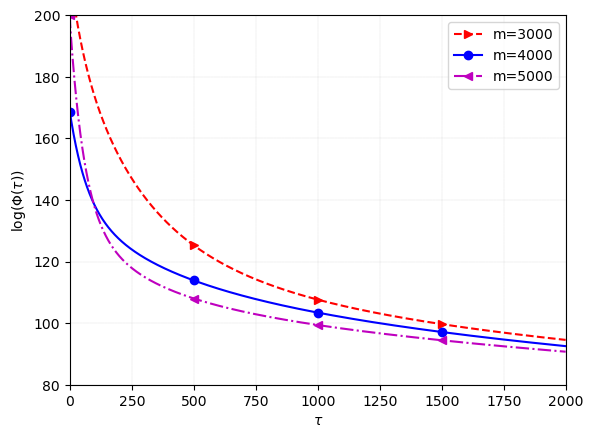

In [32]:
plt.figure(1)
plt.plot(range(epochs), loss_plot3000,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot4000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot5000,'m-.',marker='<',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['m=3000','m=4000','m=5000'])
plt.axis([0,2000,80,200])
plt.savefig('code_DEM_CIFAR10_new.pdf') 
plt.savefig('code_DEM_CIFAR10_new.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)



In [48]:
class NetReLU(nn.Module):
    def __init__(self, width, Wstd):
        super(NetReLU, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply ReLU to the sum of weighted input and bias, then scale
        y = F.relu(self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [51]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetReLU(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [53]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000ReLU = setup_and_train_ReLU(epochs, lr, 3000, Wstd)


lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.46s | loss 229.33 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.52s | loss 164.22 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.48s | loss 151.49 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.64s | loss 148.76 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.62s | loss 147.95 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.91s | loss 136.47 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.80s | loss 136.28 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.79s | loss 136.09 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.85s | loss 135.91 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  8.75s | loss 135.73 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  8.78s | loss 135.56 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  8.77s | loss 129.38 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.89s | loss 129.27 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.74s | loss 129.16 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.94s | loss 129.05 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  8.86s | loss 128.94 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.77s | loss 124.89 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.78s | loss 124.81 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  8.76s | loss 124.73 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  8.70s | loss 124.66 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  8.79s | loss 124.58 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  8.80s | loss 124.50 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.90s | loss 121.50 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  8.57s | loss 121.44 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  8.74s | loss 121.38 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  8.85s | loss 121.32 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  9.07s | loss 121.26 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.76s | loss 118.80 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  8.72s | loss 118.74 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  8.74s | loss 118.69 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  8.72s | loss 118.64 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  8.82s | loss 118.59 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  8.71s | loss 118.54 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  8.72s | loss 116.41 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  8.71s | loss 116.36 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  8.76s | loss 116.32 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  8.77s | loss 116.27 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  8.73s | loss 116.23 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  8.83s | loss 114.33 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  8.77s | loss 114.29 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  8.80s | loss 114.25 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  8.80s | loss 114.21 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  8.75s | loss 114.17 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  8.78s | loss 114.12 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  8.76s | loss 112.41 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  8.87s | loss 112.37 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.80s | loss 112.34 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  8.89s | loss 112.30 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  8.88s | loss 112.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  9

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  8.73s | loss 110.70 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  8.82s | loss 110.67 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  8.79s | loss 110.63 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  8.73s | loss 110.60 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  8.79s | loss 110.57 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  8.75s | loss 110.53 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  8.71s | loss 109.09 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  8.81s | loss 109.06 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  8.78s | loss 109.03 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  8.79s | loss 109.00 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  8.92s | loss 108.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  8.67s | loss 107.64 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  8.74s | loss 107.61 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  8.91s | loss 107.58 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  8.80s | loss 107.55 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  8.64s | loss 107.52 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  8.69s | loss 107.49 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.74s | loss 106.26 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  8.71s | loss 106.23 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  8.67s | loss 106.20 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.71s | loss 106.17 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  8.70s | loss 106.15 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  8.81s | loss 105.01 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  8.73s | loss 104.98 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  8.63s | loss 104.96 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  8.71s | loss 104.94 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  8.71s | loss 104.91 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  8.68s | loss 104.89 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  8.87s | loss 103.85 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  8.83s | loss 103.82 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  8.80s | loss 103.80 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  8.78s | loss 103.78 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  8.76s | loss 103.76 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  8.78s | loss 102.79 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  8.89s | loss 102.77 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  8.90s | loss 102.75 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  8.96s | loss 102.72 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  8.88s | loss 102.70 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8.83s | loss 102.68 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  8.82s | loss 101.76 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.79s | loss 101.74 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.72s | loss 101.72 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  8.82s | loss 101.70 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  8.69s | loss 101.68 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  8

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  8.80s | loss 100.81 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  8.76s | loss 100.79 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  8.88s | loss 100.77 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  8.86s | loss 100.75 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  8.73s | loss 100.73 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  8.75s | loss 100.71 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  8.75s | loss 99.89 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  8.83s | loss 99.87 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.86s | loss 99.85 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  8.76s | loss 99.83 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  8.91s | loss 99.81 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  8.82s 

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  8.95s | loss 99.01 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  8.73s | loss 98.99 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  8.84s | loss 98.98 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.79s | loss 98.96 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8.87s | loss 98.94 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 928 | time / epoch  8.74s 

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  9.04s | loss 98.18 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  8.79s | loss 98.16 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  8.76s | loss 98.15 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  8.91s | loss 98.13 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  8.82s | loss 98.11 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 977 | time / epoch  8.90s 

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  8.76s | loss 97.38 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  8.74s | loss 97.37 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  8.76s | loss 97.35 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  8.88s | loss 97.33 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1025 | time / epoch  8.72s | loss 97.32 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1026 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  8.83s | loss 96.63 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  8.86s | loss 96.62 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  8.84s | loss 96.60 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  8.85s | loss 96.59 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1073 | time / epoch  8.80s | loss 96.57 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1074 | time / epoch  8.85s | loss 96.56 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.90s | loss 95.90 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  8.99s | loss 95.89 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.78s | loss 95.87 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1121 | time / epoch  8.75s | loss 95.86 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1122 | time / epoch  8.99s | loss 95.85 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1123 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  8.91s | loss 95.22 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  8.78s | loss 95.21 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  8.80s | loss 95.20 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1169 | time / epoch  8.71s | loss 95.18 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1170 | time / epoch  8.81s | loss 95.17 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1171 | time / epoch  8.84s | loss 95.15 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.88s | loss 94.56 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.73s | loss 94.55 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1217 | time / epoch  8.79s | loss 94.53 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1218 | time / epoch  8.76s | loss 94.52 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1219 | time / epoch  8.86s | loss 94.51 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1220 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  8.79s | loss 93.94 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  8.71s | loss 93.92 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1265 | time / epoch  8.92s | loss 93.91 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1266 | time / epoch  8.77s | loss 93.90 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1267 | time / epoch  8.81s | loss 93.89 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1268 | time / epoch  8.87s | loss 93.87 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.71s | loss 93.32 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1313 | time / epoch  8.74s | loss 93.31 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1314 | time / epoch  8.79s | loss 93.30 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1315 | time / epoch  8.83s | loss 93.29 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1316 | time / epoch  8.81s | loss 93.28 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1317 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.83s | loss 92.74 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1361 | time / epoch  8.79s | loss 92.73 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1362 | time / epoch  8.82s | loss 92.72 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1363 | time / epoch  8.81s | loss 92.71 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1364 | time / epoch  8.79s | loss 92.69 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1365 | time / epoch  8.90s | loss 92.68 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1409 | time / epoch  8.73s | loss 92.16 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1410 | time / epoch  8.79s | loss 92.15 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1411 | time / epoch  8.86s | loss 92.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1412 | time / epoch  8.83s | loss 92.12 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1413 | time / epoch  8.84s | loss 92.11 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1414 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1457 | time / epoch  8.75s | loss 91.61 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1458 | time / epoch  8.79s | loss 91.60 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1459 | time / epoch  8.88s | loss 91.58 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1460 | time / epoch  8.71s | loss 91.57 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1461 | time / epoch  8.83s | loss 91.56 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1462 | time / epoch  8.85s | loss 91.55 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1506 | time / epoch  8.74s | loss 91.06 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1507 | time / epoch  8.83s | loss 91.05 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1508 | time / epoch  8.81s | loss 91.04 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1509 | time / epoch  8.94s | loss 91.03 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1510 | time / epoch  8.98s | loss 91.02 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1511 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1554 | time / epoch  8.76s | loss 90.55 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1555 | time / epoch  8.88s | loss 90.54 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1556 | time / epoch  8.74s | loss 90.53 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1557 | time / epoch  8.88s | loss 90.52 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1558 | time / epoch  8.85s | loss 90.51 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1559 | time / epoch  8.79s | loss 90.50 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1603 | time / epoch  8.83s | loss 90.04 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1604 | time / epoch  8.76s | loss 90.03 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1605 | time / epoch  8.85s | loss 90.02 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1606 | time / epoch  8.85s | loss 90.01 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1607 | time / epoch  8.82s | loss 90.00 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1608 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1651 | time / epoch  8.75s | loss 89.55 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1652 | time / epoch  8.77s | loss 89.54 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1653 | time / epoch  8.78s | loss 89.53 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1654 | time / epoch  8.81s | loss 89.52 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1655 | time / epoch  8.73s | loss 89.51 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1656 | time / epoch  8.77s | loss 89.50 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1700 | time / epoch  8.94s | loss 89.08 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1701 | time / epoch  8.84s | loss 89.07 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1702 | time / epoch  8.75s | loss 89.06 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1703 | time / epoch  8.73s | loss 89.05 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1704 | time / epoch  8.78s | loss 89.04 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1705 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1748 | time / epoch  8.82s | loss 88.62 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1749 | time / epoch  8.80s | loss 88.61 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1750 | time / epoch  8.80s | loss 88.60 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1751 | time / epoch  8.84s | loss 88.59 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1752 | time / epoch  8.77s | loss 88.58 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1753 | time / epoch  8.84s | loss 88.57 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1797 | time / epoch  8.87s | loss 88.16 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1798 | time / epoch  9.07s | loss 88.15 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1799 | time / epoch  8.76s | loss 88.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1800 | time / epoch  8.78s | loss 88.13 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1801 | time / epoch  8.82s | loss 88.12 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1802 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1845 | time / epoch  8.77s | loss 87.72 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1846 | time / epoch  8.81s | loss 87.71 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch  8.75s | loss 87.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1848 | time / epoch  8.77s | loss 87.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1849 | time / epoch  8.83s | loss 87.68 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1850 | time / epoch  8.87s | loss 87.67 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch  8.75s | loss 87.29 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1895 | time / epoch  8.79s | loss 87.28 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1896 | time / epoch  8.82s | loss 87.27 
lambda_min tensor(0.0018+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1897 | time / epoch  8.78s | loss 87.26 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1898 | time / epoch  8.80s | loss 87.25 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1899 | time / epoch  

singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1942 | time / epoch  8.82s | loss 86.88 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1943 | time / epoch  8.84s | loss 86.87 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1944 | time / epoch  8.79s | loss 86.86 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1945 | time / epoch  8.80s | loss 86.85 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1946 | time / epoch  8.73s | loss 86.84 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1947 | time / epoch  8.90s | loss 86.83 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1991 | time / epoch  8.80s | loss 86.47 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1992 | time / epoch  8.74s | loss 86.46 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1993 | time / epoch  8.79s | loss 86.45 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1994 | time / epoch  8.81s | loss 86.45 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1995 | time / epoch  8.89s | loss 86.44 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7973+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1996 | time / epoch  

In [68]:
class NetSIN(nn.Module):
    def __init__(self, width, Wstd):
        super(NetSIN, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply ReLU to the sum of weighted input and bias, then scale
        y = torch.sin(self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [69]:
def setup_and_train_SIN(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetSIN(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [70]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000sin=setup_and_train_SIN(epochs, lr, 3000, Wstd)

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.69s | loss 1145.35 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.82s | loss 323.84 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.78s | loss 200.97 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.93s | loss 181.79 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.88s | loss 178.01 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.99s | loss 146.78 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  9.01s | loss 146.35 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  9.31s | loss 145.93 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  9.30s | loss 145.51 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  9.24s | loss 145.10 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  9.18s | loss 144.70 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  8.77s | loss 132.22 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.68s | loss 132.02 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.77s | loss 131.83 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.74s | loss 131.63 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  8.66s | loss 131.44 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  8

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.65s | loss 124.81 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.72s | loss 124.70 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  8.87s | loss 124.58 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  8.79s | loss 124.46 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  8.68s | loss 124.34 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  8.75s | loss 124.23 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.75s | loss 119.92 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  8.78s | loss 119.84 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  8.88s | loss 119.76 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  8.78s | loss 119.67 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  8.82s | loss 119.59 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  8

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.79s | loss 116.38 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  8.79s | loss 116.31 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  8.86s | loss 116.25 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  8.91s | loss 116.18 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  8.74s | loss 116.12 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  8.76s | loss 116.06 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  8.85s | loss 113.50 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  8.72s | loss 113.45 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  8.78s | loss 113.39 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  8.82s | loss 113.34 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  8.83s | loss 113.29 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  8

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  8.82s | loss 111.17 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  8.73s | loss 111.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  8.84s | loss 111.08 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  8.81s | loss 111.03 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  8.91s | loss 110.99 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  8.85s | loss 110.94 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  8.75s | loss 109.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  8.94s | loss 109.10 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.93s | loss 109.06 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  8.89s | loss 109.03 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  8.95s | loss 108.99 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  8

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  8.75s | loss 107.42 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  8.81s | loss 107.39 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  8.69s | loss 107.36 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  8.88s | loss 107.32 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  8.73s | loss 107.29 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  8.75s | loss 107.26 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  8.67s | loss 105.88 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  8.67s | loss 105.85 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  8.74s | loss 105.82 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  8.65s | loss 105.79 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  8.79s | loss 105.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  8

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  8.79s | loss 104.53 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  8.73s | loss 104.50 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  8.76s | loss 104.48 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  8.78s | loss 104.45 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  8.79s | loss 104.42 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  8.74s | loss 104.40 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.86s | loss 103.29 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  8.72s | loss 103.27 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  8.70s | loss 103.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.69s | loss 103.22 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  8.73s | loss 103.19 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  8

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  8.80s | loss 102.18 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  8.77s | loss 102.16 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  8.76s | loss 102.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  8.73s | loss 102.12 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  8.88s | loss 102.09 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  8.84s | loss 102.07 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  8.83s | loss 101.14 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  8.72s | loss 101.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  8.68s | loss 101.10 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  8.74s | loss 101.08 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  8.66s | loss 101.06 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  8

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  8.76s | loss 100.20 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  8.78s | loss 100.18 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  8.77s | loss 100.16 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  8.87s | loss 100.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  8.72s | loss 100.13 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8.74s | loss 100.11 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  8.75s | loss 99.30 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.73s | loss 99.29 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.75s | loss 99.27 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  8.79s | loss 99.25 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  8.84s | loss 99.23 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  8.84s 

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  8.69s | loss 98.47 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  8.71s | loss 98.45 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  8.80s | loss 98.43 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  8.66s | loss 98.42 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  8.73s | loss 98.40 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 831 | time / epoch  8.72s 

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  8.77s | loss 97.68 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.80s | loss 97.66 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  8.77s | loss 97.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  8.72s | loss 97.63 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  8.73s | loss 97.61 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 880 | time / epoch  8.80s 

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  8.78s | loss 96.93 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  8.69s | loss 96.91 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.80s | loss 96.90 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8.74s | loss 96.88 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 928 | time / epoch  8.80s | loss 96.87 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 929 | time / epoch  8.84s 

| end of epoch 972 | time / epoch  9.39s | loss 96.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch 10.19s | loss 96.22 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  9.94s | loss 96.21 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  9.98s | loss 96.19 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch 10.03s | loss 96.18 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 977 | time / epoch  9.73s | loss 96.16 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<Sq

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  9.84s | loss 95.56 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  9.72s | loss 95.55 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  9.72s | loss 95.53 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  9.90s | loss 95.52 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1025 | time / epoch  9.83s | loss 95.51 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1026 | time / epoch  9.87s | loss 95.49 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  8.68s | loss 94.92 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  8.73s | loss 94.90 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  8.67s | loss 94.89 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1073 | time / epoch  8.66s | loss 94.88 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1074 | time / epoch  8.67s | loss 94.86 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1075 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.65s | loss 94.31 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  8.69s | loss 94.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.84s | loss 94.29 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1121 | time / epoch  8.77s | loss 94.27 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1122 | time / epoch  8.71s | loss 94.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1123 | time / epoch  8.63s | loss 94.25 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  8.71s | loss 93.72 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  8.61s | loss 93.71 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1169 | time / epoch  8.66s | loss 93.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1170 | time / epoch  8.70s | loss 93.68 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1171 | time / epoch  8.68s | loss 93.67 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1172 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.73s | loss 93.16 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.71s | loss 93.15 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1217 | time / epoch  8.88s | loss 93.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1218 | time / epoch  8.68s | loss 93.13 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1219 | time / epoch  8.71s | loss 93.12 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1220 | time / epoch  8.71s | loss 93.10 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  8.78s | loss 92.61 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1265 | time / epoch  8.73s | loss 92.60 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1266 | time / epoch  8.78s | loss 92.59 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1267 | time / epoch  8.86s | loss 92.58 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1268 | time / epoch  8.71s | loss 92.57 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1269 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.84s | loss 92.09 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1313 | time / epoch  8.83s | loss 92.08 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1314 | time / epoch  8.78s | loss 92.07 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1315 | time / epoch  8.71s | loss 92.06 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1316 | time / epoch  8.78s | loss 92.05 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1317 | time / epoch  8.80s | loss 92.04 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1361 | time / epoch  8.80s | loss 91.58 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1362 | time / epoch  8.63s | loss 91.57 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1363 | time / epoch  8.84s | loss 91.56 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1364 | time / epoch  8.73s | loss 91.55 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1365 | time / epoch  8.76s | loss 91.54 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1366 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1409 | time / epoch  8.64s | loss 91.09 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1410 | time / epoch  8.78s | loss 91.08 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1411 | time / epoch  8.67s | loss 91.07 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1412 | time / epoch  8.60s | loss 91.06 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1413 | time / epoch  8.69s | loss 91.05 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1414 | time / epoch  8.64s | loss 91.04 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1458 | time / epoch  8.74s | loss 90.61 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1459 | time / epoch  8.70s | loss 90.60 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1460 | time / epoch  8.80s | loss 90.59 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1461 | time / epoch  8.72s | loss 90.58 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1462 | time / epoch  8.73s | loss 90.57 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1463 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1506 | time / epoch  8.85s | loss 90.16 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1507 | time / epoch  8.88s | loss 90.15 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1508 | time / epoch  9.10s | loss 90.14 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1509 | time / epoch  8.79s | loss 90.13 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1510 | time / epoch  8.78s | loss 90.12 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1511 | time / epoch  8.86s | loss 90.11 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1555 | time / epoch  8.86s | loss 89.70 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1556 | time / epoch  8.84s | loss 89.69 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1557 | time / epoch  9.00s | loss 89.68 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1558 | time / epoch  8.90s | loss 89.67 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1559 | time / epoch  8.90s | loss 89.67 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1560 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1603 | time / epoch  8.88s | loss 89.27 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1604 | time / epoch  8.88s | loss 89.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1605 | time / epoch  8.98s | loss 89.25 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1606 | time / epoch  8.96s | loss 89.24 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1607 | time / epoch  8.90s | loss 89.23 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1608 | time / epoch  8.95s | loss 89.23 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1652 | time / epoch  8.83s | loss 88.84 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1653 | time / epoch  8.88s | loss 88.83 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1654 | time / epoch  8.90s | loss 88.82 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1655 | time / epoch  8.85s | loss 88.81 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1656 | time / epoch  9.05s | loss 88.81 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1657 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1700 | time / epoch  8.88s | loss 88.43 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1701 | time / epoch  8.86s | loss 88.42 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1702 | time / epoch  8.91s | loss 88.41 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1703 | time / epoch  9.02s | loss 88.40 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1704 | time / epoch  8.99s | loss 88.40 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1705 | time / epoch  8.98s | loss 88.39 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1749 | time / epoch  9.05s | loss 88.02 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1750 | time / epoch  8.93s | loss 88.01 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1751 | time / epoch  8.89s | loss 88.00 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1752 | time / epoch  8.91s | loss 88.00 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1753 | time / epoch  9.11s | loss 87.99 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1754 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1797 | time / epoch  8.90s | loss 87.63 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1798 | time / epoch  8.87s | loss 87.62 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1799 | time / epoch  8.89s | loss 87.61 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1800 | time / epoch  8.94s | loss 87.61 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1801 | time / epoch  9.04s | loss 87.60 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1802 | time / epoch  8.89s | loss 87.59 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1846 | time / epoch  8.86s | loss 87.24 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch  8.89s | loss 87.23 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1848 | time / epoch  8.96s | loss 87.23 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1849 | time / epoch  8.89s | loss 87.22 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1850 | time / epoch  8.91s | loss 87.21 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1851 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch  9.03s | loss 86.87 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1895 | time / epoch  8.99s | loss 86.86 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1896 | time / epoch  8.93s | loss 86.85 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1897 | time / epoch  8.90s | loss 86.85 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1898 | time / epoch  8.96s | loss 86.84 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1899 | time / epoch  8.94s | loss 86.83 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1943 | time / epoch  8.87s | loss 86.50 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1944 | time / epoch  8.97s | loss 86.49 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1945 | time / epoch  8.98s | loss 86.48 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1946 | time / epoch  9.06s | loss 86.47 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1947 | time / epoch  8.98s | loss 86.47 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1948 | time / epoch  

singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1991 | time / epoch  8.87s | loss 86.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1992 | time / epoch  8.97s | loss 86.13 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1993 | time / epoch  8.85s | loss 86.12 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1994 | time / epoch  8.89s | loss 86.12 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1995 | time / epoch  8.90s | loss 86.11 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7986+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1996 | time / epoch  8.87s | loss 86.10 
lambda_min tensor(0.0008+0.j, grad_fn

In [79]:
# Identity activation
class NetIDENTITY(nn.Module):
    def __init__(self, width, Wstd):
        super(NetIDENTITY, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply sin to the sum of weighted input and bias, then scale
        y = (self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [80]:
def setup_and_train_IDENTITY(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetIDENTITY(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [81]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000identity=setup_and_train_IDENTITY(epochs, lr, 3000, Wstd)

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.78s | loss 852.09 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.90s | loss 397.88 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.78s | loss 345.61 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.78s | loss 335.52 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.86s | loss 330.00 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  9.07s | loss 225.14 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  9.20s | loss 224.14 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  9.07s | loss 223.18 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  9.55s | loss 222.24 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  8.95s | loss 221.33 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  9.00s | loss 220.44 
lambda_min tensor(0.0002+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  9.38s | loss 196.52 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  9.10s | loss 196.17 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  9.30s | loss 195.82 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  9.07s | loss 195.48 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  9.41s | loss 195.15 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  9.19s | loss 183.40 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  9.03s | loss 183.18 
lambda_min tensor(9.0487e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  9.12s | loss 182.96 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  9.08s | loss 182.74 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  9.11s | loss 182.53 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  9.18s | loss 182.31 
lambda_min tensor(0.0006+0.j, gra

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  9.06s | loss 174.05 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  9.06s | loss 173.88 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  9.17s | loss 173.72 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  9.08s | loss 173.55 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  9.12s | loss 173.39 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  9.21s | loss 166.89 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  9.11s | loss 166.76 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  9.28s | loss 166.63 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  9.17s | loss 166.50 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  9.15s | loss 166.36 
lambda_min tensor(8.5771e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  9.12s | loss 166.23 
lambda_min tensor(0.0002+0.j, gra

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  9.13s | loss 160.95 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  9.21s | loss 160.84 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  9.20s | loss 160.73 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  9.02s | loss 160.62 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  8.96s | loss 160.51 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  9.26s | loss 156.09 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  9.36s | loss 155.99 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  9.33s | loss 155.90 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  9.06s | loss 155.81 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  9.09s | loss 155.72 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  9.18s | loss 155.63 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  9.14s | loss 151.85 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  9.10s | loss 151.77 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  9.12s | loss 151.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  9.21s | loss 151.61 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  9.14s | loss 151.53 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  9.15s | loss 148.24 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  9.13s | loss 148.17 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  9.09s | loss 148.10 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  9.05s | loss 148.03 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  9.27s | loss 147.96 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  9.11s | loss 147.90 
lambda_min tensor(0.0002+0.j, grad_fn

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  9.23s | loss 145.00 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  9.12s | loss 144.93 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  9.16s | loss 144.87 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  9.07s | loss 144.81 
lambda_min tensor(5.1748e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  9.29s | loss 144.75 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoc

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  9.13s | loss 142.15 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  9.09s | loss 142.10 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  9.20s | loss 142.04 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  9.17s | loss 141.98 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  9.07s | loss 141.93 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  9.17s | loss 141.87 
lambda_min tensor(0.0004+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  9.12s | loss 139.53 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  9.07s | loss 139.48 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  9.02s | loss 139.43 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  9.33s | loss 139.38 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  9.11s | loss 139.32 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  9.36s | loss 137.18 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  9.12s | loss 137.14 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  9.04s | loss 137.09 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  9.04s | loss 137.04 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  9.17s | loss 137.00 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  9.03s | loss 136.95 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  9.11s | loss 134.99 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  9.12s | loss 134.94 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  9.00s | loss 134.90 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  9.09s | loss 134.86 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  9.03s | loss 134.81 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  9.10s | loss 132.99 
lambda_min tensor(8.8657e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  9.05s | loss 132.95 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  8.99s | loss 132.91 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  9.08s | loss 132.88 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  9.06s | loss 132.84 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8.97s | loss 132.80 
lambda_min tensor(0.0004+0.j, gra

lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  9.07s | loss 131.11 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  9.14s | loss 131.07 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  9.31s | loss 131.03 
lambda_min tensor(7.6746e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  9.05s | loss 130.99 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  9.14s | loss 130.96 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoc

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  9.06s | loss 129.38 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  9.17s | loss 129.34 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  9.13s | loss 129.31 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  9.01s | loss 129.27 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  9.03s | loss 129.24 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  9.05s | loss 129.20 
lambda_min tensor(0.0002+0.j, grad_fn

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  9.17s | loss 127.72 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  9.12s | loss 127.69 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  9.16s | loss 127.66 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  9.10s | loss 127.62 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  9.07s | loss 127.59 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  9.24s | loss 126.20 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  9.06s | loss 126.16 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  9.21s | loss 126.13 
lambda_min tensor(4.4489e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  9.01s | loss 126.10 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  9.11s | loss 126.07 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  9.18s | loss 126.04 
lambda_min tensor(1.0460e-05+0.j,

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  9.13s | loss 124.73 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  9.02s | loss 124.70 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  9.12s | loss 124.67 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  9.23s | loss 124.64 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  9.32s | loss 124.61 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  9

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1019 | time / epoch  9.07s | loss 123.36 
lambda_min tensor(9.7736e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch  8.96s | loss 123.34 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  9.04s | loss 123.31 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  9.11s | loss 123.28 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  9.09s | loss 123.25 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  9.21s | loss 123.23 
lambda_min tensor(0.0005+0.

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1067 | time / epoch  9.08s | loss 122.07 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch  9.03s | loss 122.04 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  9.15s | loss 122.02 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  9.15s | loss 121.99 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  9.07s | loss 121.97 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  9.06s | loss 121.94 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1115 | time / epoch  9.10s | loss 120.84 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1116 | time / epoch  9.16s | loss 120.82 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  9.11s | loss 120.79 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  9.05s | loss 120.77 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  9.01s | loss 120.74 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  9.12s | loss 120.72 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1163 | time / epoch  9.14s | loss 119.67 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1164 | time / epoch  9.11s | loss 119.65 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  9.09s | loss 119.62 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  9.14s | loss 119.60 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  9.00s | loss 119.57 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  9.01s | loss 119.55 
lambda_min tensor(0.0002+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1211 | time / epoch  9.03s | loss 118.55 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1212 | time / epoch  9.17s | loss 118.53 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1213 | time / epoch  9.18s | loss 118.51 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / epoch  9.06s | loss 118.48 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  9.24s | loss 118.46 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  9.03s | loss 118.44 
lambda_min tensor(0.0001+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1259 | time / epoch  9.03s | loss 117.48 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1260 | time / epoch  9.10s | loss 117.46 
lambda_min tensor(0.0002-2.0452e-07j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1261 | time / epoch  9.19s | loss 117.44 
lambda_min tensor(7.9188e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / epoch  9.03s | loss 117.42 
lambda_min tensor(6.7718e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  9.10s | loss 117.40 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  9.24s | loss 117.37 
lambda_min tens

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1307 | time / epoch  9.19s | loss 116.46 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1308 | time / epoch  9.05s | loss 116.44 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1309 | time / epoch  9.22s | loss 116.42 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1310 | time / epoch  9.06s | loss 116.40 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1311 | time / epoch  9.30s | loss 116.38 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  9.27s | loss 116.36 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1355 | time / epoch  8.93s | loss 115.48 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1356 | time / epoch  9.06s | loss 115.46 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1357 | time / epoch  9.12s | loss 115.44 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1358 | time / epoch  9.03s | loss 115.42 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1359 | time / epoch  9.18s | loss 115.40 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  9.06s | loss 115.38 
lambda_min tensor(2.7290e-05+0.

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1403 | time / epoch  9.05s | loss 114.54 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1404 | time / epoch  9.05s | loss 114.52 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1405 | time / epoch  9.16s | loss 114.50 
lambda_min tensor(0.0002-2.5939e-07j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1406 | time / epoch  9.01s | loss 114.48 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1407 | time / epoch  9.18s | loss 114.46 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1408 | time / epoch  9.12s | loss 114.44 
lambda_min tensor(0.000

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1451 | time / epoch  9.33s | loss 113.63 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1452 | time / epoch  9.15s | loss 113.62 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1453 | time / epoch  8.97s | loss 113.60 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1454 | time / epoch  9.25s | loss 113.58 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1455 | time / epoch  9.21s | loss 113.56 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1456 | time / epoch  8.95s | loss 113.54 
lambda_min tensor(0.0004+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1499 | time / epoch  9.07s | loss 112.77 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1500 | time / epoch  9.08s | loss 112.75 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1501 | time / epoch  9.13s | loss 112.73 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1502 | time / epoch  9.15s | loss 112.71 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1503 | time / epoch  9.15s | loss 112.69 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1504 | time / epoch  9.18s | loss 112.68 
lambda_min tensor(0.0002+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1547 | time / epoch  9.05s | loss 111.93 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1548 | time / epoch  9.05s | loss 111.91 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1549 | time / epoch  9.04s | loss 111.89 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1550 | time / epoch  9.50s | loss 111.88 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1551 | time / epoch  8.94s | loss 111.86 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1552 | time / epoch  9.23s | loss 111.84 
lambda_min tensor(0.0002+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1595 | time / epoch  9.14s | loss 111.12 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1596 | time / epoch  9.00s | loss 111.11 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1597 | time / epoch  9.24s | loss 111.09 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1598 | time / epoch  9.22s | loss 111.07 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1599 | time / epoch  8.99s | loss 111.06 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1600 | time / epoch  9.06s | loss 111.04 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1643 | time / epoch  9.16s | loss 110.34 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1644 | time / epoch  9.11s | loss 110.33 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1645 | time / epoch  9.14s | loss 110.31 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  9.22s | loss 110.30 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1647 | time / epoch  8.98s | loss 110.28 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1648 | time / epoch  9.08s | loss 110.26 
lambda_min tensor(0.0001+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1691 | time / epoch  9.05s | loss 109.59 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1692 | time / epoch  9.16s | loss 109.58 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1693 | time / epoch  9.06s | loss 109.56 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  9.00s | loss 109.55 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1695 | time / epoch  9.06s | loss 109.53 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1696 | time / epoch  9.22s | loss 109.52 
lambda_min tensor(0.0002+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1739 | time / epoch  9.18s | loss 108.87 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1740 | time / epoch  9.26s | loss 108.85 
lambda_min tensor(9.0405e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1741 | time / epoch  9.10s | loss 108.84 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  9.08s | loss 108.82 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1743 | time / epoch  9.29s | loss 108.81 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1744 | time / epoch  9.11s | loss 108.79 
lambda_min tensor(0.0002+0.

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1787 | time / epoch  9.03s | loss 108.17 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1788 | time / epoch  9.22s | loss 108.15 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1789 | time / epoch  9.05s | loss 108.14 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1790 | time / epoch  9.22s | loss 108.12 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  8.99s | loss 108.11 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1792 | time / epoch  9.21s | loss 108.09 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1835 | time / epoch  9.09s | loss 107.49 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1836 | time / epoch  9.06s | loss 107.47 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1837 | time / epoch  9.02s | loss 107.46 
lambda_min tensor(8.5923e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1838 | time / epoch  9.12s | loss 107.44 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1839 | time / epoch  9.27s | loss 107.43 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1840 | time / epoch  9.05s | loss 107.42 
lambda_min tensor(0.0003+0.

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1883 | time / epoch  9.30s | loss 106.83 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1884 | time / epoch  9.17s | loss 106.82 
lambda_min tensor(9.4244e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1885 | time / epoch  9.02s | loss 106.80 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1886 | time / epoch  9.09s | loss 106.79 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1887 | time / epoch  9.10s | loss 106.77 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1888 | time / epoch  9.19s | loss 106.76 
lambda_min tensor(0.0004+0.

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1931 | time / epoch  9.06s | loss 106.19 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1932 | time / epoch  9.15s | loss 106.18 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1933 | time / epoch  9.12s | loss 106.17 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1934 | time / epoch  9.25s | loss 106.15 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1935 | time / epoch  9.17s | loss 106.14 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1936 | time / epoch  9.14s | loss 106.13 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1979 | time / epoch  9.18s | loss 105.57 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1980 | time / epoch  9.38s | loss 105.56 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1981 | time / epoch  9.10s | loss 105.55 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1982 | time / epoch  9.23s | loss 105.54 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1983 | time / epoch  9.07s | loss 105.52 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8001+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1984 | time / epoch  9.30s | loss 105.51 
lambda_min tensor(0.0002+0.j, g

In [85]:
# Swish activation x sigma(x)
class NetSWISH(nn.Module):
    def __init__(self, width, Wstd):
        super(NetSWISH, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply swish to the sum of weighted input and bias, then scale
        y = (self.wmatrix(z) + x)*F.sigmoid(self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [86]:
def setup_and_train_SWISH(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetSWISH(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [87]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000swish=setup_and_train_SWISH(epochs, lr, 3000, Wstd)

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.79s | loss 459.95 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.82s | loss 252.72 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.90s | loss 203.99 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  9.06s | loss 192.16 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  9.00s | loss 188.93 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.94s | loss 166.28 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  9.01s | loss 165.89 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.86s | loss 165.51 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  9.15s | loss 165.13 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  9.01s | loss 164.76 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  9.06s | loss 164.38 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  9.02s | loss 151.22 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  9.08s | loss 150.98 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.94s | loss 150.74 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.95s | loss 150.51 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  9.03s | loss 150.27 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  9.02s | loss 141.85 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.98s | loss 141.69 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  9.01s | loss 141.54 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  9.04s | loss 141.38 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  9.03s | loss 141.23 
lambda_min tensor(0.0001+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  9.24s | loss 141.07 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.97s | loss 135.40 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  9.06s | loss 135.29 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  9.07s | loss 135.18 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  9.13s | loss 135.08 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  9.05s | loss 134.97 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  9.07s | loss 130.87 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  9.21s | loss 130.79 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  9.05s | loss 130.71 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  9.00s | loss 130.63 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  8.97s | loss 130.55 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  9.02s | loss 130.47 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  8.99s | loss 127.34 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  9.03s | loss 127.28 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  8.99s | loss 127.22 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  8.99s | loss 127.15 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  9.00s | loss 127.09 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  9.02s | loss 124.57 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  9.15s | loss 124.52 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  9.04s | loss 124.46 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  9.03s | loss 124.41 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  9.00s | loss 124.36 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  9.02s | loss 124.31 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  9.03s | loss 122.19 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  9.09s | loss 122.15 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  9.26s | loss 122.11 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  9.03s | loss 122.06 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  8.97s | loss 122.02 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  9.03s | loss 120.18 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  8.99s | loss 120.15 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  9.02s | loss 120.11 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  9.09s | loss 120.07 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  9.11s | loss 120.03 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  9.01s | loss 119.99 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  9.12s | loss 118.37 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  9.00s | loss 118.34 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  9.14s | loss 118.30 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  9.01s | loss 118.27 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  9.08s | loss 118.23 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  9.04s | loss 116.78 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  9.20s | loss 116.75 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  9.03s | loss 116.72 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  9.10s | loss 116.69 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  9.03s | loss 116.65 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  9.03s | loss 116.62 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.93s | loss 115.30 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  9.18s | loss 115.28 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  9.02s | loss 115.25 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.98s | loss 115.22 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  9.04s | loss 115.19 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  9.01s | loss 113.98 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  9.06s | loss 113.96 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  9.12s | loss 113.93 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  9.04s | loss 113.90 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  9.08s | loss 113.88 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  9.00s | loss 113.85 
lambda_min tensor(0.0004+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  9.01s | loss 112.74 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  9.06s | loss 112.72 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  8.94s | loss 112.69 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  9.02s | loss 112.67 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  9.18s | loss 112.64 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  9.06s | loss 111.61 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  8.97s | loss 111.59 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  9.05s | loss 111.57 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  9.05s | loss 111.55 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  9.16s | loss 111.52 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  9.16s | loss 111.50 
lambda_min tensor(0.0004+0.j, grad_fn

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  9.13s | loss 110.55 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  9.01s | loss 110.53 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.95s | loss 110.51 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  9.01s | loss 110.48 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  9.01s | loss 110.46 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  8.98s | loss 109.57 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  9.05s | loss 109.55 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  9.11s | loss 109.53 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  9.04s | loss 109.51 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  8.85s | loss 109.49 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  8.95s | loss 109.47 
lambda_min tensor(0.0002+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  9.08s | loss 108.64 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  9.02s | loss 108.62 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  9.03s | loss 108.61 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  9.01s | loss 108.59 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  9.01s | loss 108.57 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  8

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  9.21s | loss 107.79 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  8.93s | loss 107.77 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  9.02s | loss 107.75 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  8.91s | loss 107.74 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.84s | loss 107.72 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8.95s | loss 107.70 
lambda_min tensor(0.0004+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  8.91s | loss 106.97 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  8.89s | loss 106.95 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  8.96s | loss 106.93 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  9.22s | loss 106.92 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  9.18s | loss 106.90 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  9

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1019 | time / epoch  9.10s | loss 106.21 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch  9.00s | loss 106.19 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  9.01s | loss 106.18 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  8.95s | loss 106.16 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  9.00s | loss 106.15 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  9.00s | loss 106.13 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1067 | time / epoch  9.03s | loss 105.49 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch  8.96s | loss 105.48 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  8.93s | loss 105.46 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  8.94s | loss 105.45 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  8.93s | loss 105.44 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  8.94s | loss 105.42 
lambda_min tensor(0.0004+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1115 | time / epoch  8.89s | loss 104.81 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1116 | time / epoch  9.16s | loss 104.80 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  8.93s | loss 104.79 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.89s | loss 104.77 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  9.07s | loss 104.76 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.94s | loss 104.75 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1163 | time / epoch  8.94s | loss 104.17 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1164 | time / epoch  8.92s | loss 104.16 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  8.76s | loss 104.14 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  8.97s | loss 104.13 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  9.30s | loss 104.12 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  9.04s | loss 104.10 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1211 | time / epoch  8.98s | loss 103.56 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1212 | time / epoch  9.04s | loss 103.54 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1213 | time / epoch  9.10s | loss 103.53 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / epoch  9.05s | loss 103.52 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.94s | loss 103.51 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.97s | loss 103.49 
lambda_min tensor(0.0002+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1259 | time / epoch  8.96s | loss 102.97 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1260 | time / epoch  8.98s | loss 102.96 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1261 | time / epoch  9.01s | loss 102.95 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / epoch  9.04s | loss 102.94 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  9.09s | loss 102.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  9.08s | loss 102.91 
lambda_min tensor(0.0005+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1307 | time / epoch  9.03s | loss 102.41 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1308 | time / epoch  8.94s | loss 102.40 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1309 | time / epoch  8.99s | loss 102.39 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1310 | time / epoch  8.91s | loss 102.38 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1311 | time / epoch  9.15s | loss 102.37 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.93s | loss 102.36 
lambda_min tensor(0.0005+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1355 | time / epoch  9.00s | loss 101.88 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1356 | time / epoch  8.95s | loss 101.87 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1357 | time / epoch  9.45s | loss 101.86 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1358 | time / epoch  9.16s | loss 101.84 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1359 | time / epoch  8.94s | loss 101.83 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.94s | loss 101.82 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1403 | time / epoch  8.90s | loss 101.37 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1404 | time / epoch  9.06s | loss 101.35 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1405 | time / epoch  8.96s | loss 101.34 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1406 | time / epoch  9.02s | loss 101.33 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1407 | time / epoch  8.91s | loss 101.32 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1408 | time / epoch  9.12s | loss 101.31 
lambda_min tensor(0.0003+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1451 | time / epoch  9.00s | loss 100.87 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1452 | time / epoch  8.96s | loss 100.86 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1453 | time / epoch  8.93s | loss 100.85 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1454 | time / epoch  8.93s | loss 100.84 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1455 | time / epoch  8.95s | loss 100.83 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1456 | time / epoch  8.99s | loss 100.82 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1499 | time / epoch  8.97s | loss 100.40 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1500 | time / epoch  8.93s | loss 100.39 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1501 | time / epoch  9.00s | loss 100.38 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1502 | time / epoch  8.94s | loss 100.37 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1503 | time / epoch  9.15s | loss 100.36 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1504 | time / epoch  8.92s | loss 100.35 
lambda_min tensor(0.0002+0.j, g

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1547 | time / epoch  9.14s | loss 99.95 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1548 | time / epoch  8.89s | loss 99.94 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1549 | time / epoch  9.02s | loss 99.93 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1550 | time / epoch  9.04s | loss 99.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1551 | time / epoch  9.28s | loss 99.91 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1552 | time / epoch  9.03s | loss 99.90 
lambda_min tensor(0.0005+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1596 | time / epoch  9.10s | loss 99.50 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1597 | time / epoch  9.30s | loss 99.49 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1598 | time / epoch  9.02s | loss 99.48 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1599 | time / epoch  9.05s | loss 99.47 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1600 | time / epoch  9.04s | loss 99.46 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1601 | time / epoch  

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1644 | time / epoch  9.19s | loss 99.08 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1645 | time / epoch  9.07s | loss 99.07 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  8.99s | loss 99.06 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1647 | time / epoch  8.96s | loss 99.05 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1648 | time / epoch  9.10s | loss 99.04 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1649 | time / epoch  9.13s | loss 99.03 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1693 | time / epoch  9.08s | loss 98.66 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  9.05s | loss 98.65 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1695 | time / epoch  9.06s | loss 98.64 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1696 | time / epoch  9.10s | loss 98.63 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1697 | time / epoch  9.07s | loss 98.63 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1698 | time / epoch  

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1741 | time / epoch  9.01s | loss 98.26 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  9.00s | loss 98.26 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1743 | time / epoch  9.08s | loss 98.25 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1744 | time / epoch  9.07s | loss 98.24 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1745 | time / epoch  9.00s | loss 98.23 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1746 | time / epoch  9.02s | loss 98.22 
lambda_min tensor(0.0002+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1790 | time / epoch  9.04s | loss 97.87 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  9.06s | loss 97.87 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1792 | time / epoch  9.03s | loss 97.86 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1793 | time / epoch  9.06s | loss 97.85 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1794 | time / epoch  8.99s | loss 97.84 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1795 | time / epoch  

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1838 | time / epoch  9.26s | loss 97.50 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1839 | time / epoch  9.10s | loss 97.50 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1840 | time / epoch  9.16s | loss 97.49 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1841 | time / epoch  9.04s | loss 97.48 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1842 | time / epoch  9.11s | loss 97.47 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1843 | time / epoch  9.06s | loss 97.46 
lambda_min tensor(0.0004+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1887 | time / epoch  9.24s | loss 97.14 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1888 | time / epoch  8.98s | loss 97.13 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1889 | time / epoch  9.00s | loss 97.12 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1890 | time / epoch  9.18s | loss 97.11 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1891 | time / epoch  9.24s | loss 97.11 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1892 | time / epoch  

singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1935 | time / epoch  8.97s | loss 96.79 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1936 | time / epoch  9.07s | loss 96.78 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1937 | time / epoch  9.02s | loss 96.77 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1938 | time / epoch  9.07s | loss 96.76 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1939 | time / epoch  9.10s | loss 96.76 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1940 | time / epoch  9.04s | loss 96.75 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1984 | time / epoch  9.05s | loss 96.44 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1985 | time / epoch  9.09s | loss 96.43 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1986 | time / epoch  9.19s | loss 96.43 
lambda_min tensor(0.0002+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1987 | time / epoch  9.00s | loss 96.42 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1988 | time / epoch  9.06s | loss 96.41 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7985+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1989 | time / epoch  

In [227]:
# MISH activation
class NetMISH(nn.Module):
    def __init__(self, width, Wstd):
        super(NetMISH, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply sin to the sum of weighted input and bias, then scale
        y = (self.wmatrix(z) + x) * torch.tanh(torch.nn.functional.softplus((self.wmatrix(z) + x)))* math.sqrt(1 / self.width)
        return y

In [228]:
def setup_and_train_MISH(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetMISH(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot  

In [230]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000mish=setup_and_train_MISH(epochs, lr, 3000, Wstd)

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.79s | loss 464.42 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.93s | loss 220.24 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.76s | loss 182.64 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  9.06s | loss 176.39 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.88s | loss 174.92 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  9

singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  9.07s | loss 155.06 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  9.00s | loss 154.75 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  9.03s | loss 154.43 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  9.02s | loss 154.13 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  9.01s | loss 153.83 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  8.98s | loss 153.53 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch  97 | time / epoch  8.99s | loss 143.75 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  9.00s | loss 143.57 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  9.24s | loss 143.40 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7980+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.98s | loss 143.23 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.90s | loss 143.06 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  8.91s | loss 142.90 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.91s | loss 136.98 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.99s | loss 136.87 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  9.07s | loss 136.76 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  8.97s | loss 136.65 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  9.19s | loss 136.54 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  8

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 194 | time / epoch  8.91s | loss 132.48 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.98s | loss 132.40 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  9.02s | loss 132.32 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  9.08s | loss 132.24 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  9.05s | loss 132.16 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  9.01s | loss 132.08 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.91s | loss 128.99 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  8.91s | loss 128.93 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  8.94s | loss 128.87 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  9.03s | loss 128.81 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  9.08s | loss 128.74 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  9

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 291 | time / epoch  8.91s | loss 126.21 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  9.01s | loss 126.16 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  9.14s | loss 126.10 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  9.03s | loss 126.05 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  9.00s | loss 126.00 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  8.92s | loss 125.95 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 339 | time / epoch  9.20s | loss 123.84 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  9.04s | loss 123.79 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  9.02s | loss 123.75 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  9.28s | loss 123.70 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  9.04s | loss 123.65 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  9.08s | loss 123.61 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 388 | time / epoch  9.03s | loss 121.73 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  8.99s | loss 121.68 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  9.00s | loss 121.64 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.97s | loss 121.60 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  9.03s | loss 121.56 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  9

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 436 | time / epoch  9.12s | loss 119.89 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  9.32s | loss 119.86 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  9.16s | loss 119.82 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  9.12s | loss 119.79 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  9.13s | loss 119.75 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  9.08s | loss 119.71 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 485 | time / epoch  8.98s | loss 118.22 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  9.11s | loss 118.19 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  9.21s | loss 118.15 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  9.07s | loss 118.12 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  9.10s | loss 118.09 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  8

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 533 | time / epoch  9.11s | loss 116.74 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  9.09s | loss 116.71 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  8.97s | loss 116.68 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  8.93s | loss 116.65 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  8.94s | loss 116.62 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  8.87s | loss 116.59 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 581 | time / epoch  9.04s | loss 115.39 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 582 | time / epoch  9.12s | loss 115.36 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.99s | loss 115.34 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  8.89s | loss 115.31 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  8.96s | loss 115.28 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.95s | loss 115.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 630 | time / epoch  9.09s | loss 114.13 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  8.90s | loss 114.11 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  8.99s | loss 114.08 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  9.03s | loss 114.06 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  9.00s | loss 114.03 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  9

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 678 | time / epoch  9.06s | loss 113.00 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 679 | time / epoch  9.09s | loss 112.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  9.22s | loss 112.95 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  9.09s | loss 112.93 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  9.02s | loss 112.90 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  9.13s | loss 112.88 
lambda_min tensor(0.0004+0.j, grad_fn

| end of epoch 726 | time / epoch  9.04s | loss 111.94 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 727 | time / epoch  9.10s | loss 111.92 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  9.01s | loss 111.90 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  9.03s | loss 111.88 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  9.00s | loss 111.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  9.10s | loss 111.84 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 775 | time / epoch  9.05s | loss 110.95 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 776 | time / epoch  9.08s | loss 110.93 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  8.97s | loss 110.91 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.98s | loss 110.89 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.91s | loss 110.87 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  9

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 823 | time / epoch  9.04s | loss 110.04 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 824 | time / epoch  8.95s | loss 110.02 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  9.07s | loss 110.00 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  9.08s | loss 109.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  9.10s | loss 109.96 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  9.04s | loss 109.94 
lambda_min tensor(0.0003+0.j, grad_fn

| end of epoch 871 | time / epoch  9.15s | loss 109.18 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 872 | time / epoch  9.10s | loss 109.16 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 873 | time / epoch  9.28s | loss 109.15 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  8.96s | loss 109.13 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  8.95s | loss 109.11 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.99s | loss 109.10 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 920 | time / epoch  9.11s | loss 108.36 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 921 | time / epoch  9.02s | loss 108.35 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  8.99s | loss 108.33 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  8.96s | loss 108.31 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  9.16s | loss 108.30 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  9

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 968 | time / epoch  8.96s | loss 107.60 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 969 | time / epoch  8.96s | loss 107.59 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 970 | time / epoch  9.10s | loss 107.57 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  9.03s | loss 107.56 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  9.07s | loss 107.54 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  9.05s | loss 107.53 
lambda_min tensor(0.0005+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1017 | time / epoch  9.00s | loss 106.87 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1018 | time / epoch  8.90s | loss 106.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1019 | time / epoch  9.12s | loss 106.84 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch  8.86s | loss 106.83 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  9.02s | loss 106.81 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / ep

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1065 | time / epoch  9.06s | loss 106.19 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1066 | time / epoch  9.00s | loss 106.18 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1067 | time / epoch  8.94s | loss 106.16 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch  8.96s | loss 106.15 
lambda_min tensor(0.0003-1.2206e-07j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  9.10s | loss 106.13 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | t

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1113 | time / epoch  9.11s | loss 105.54 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1114 | time / epoch  9.10s | loss 105.53 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1115 | time / epoch  9.01s | loss 105.51 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1116 | time / epoch  9.12s | loss 105.50 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  8.99s | loss 105.49 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / ep

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1161 | time / epoch  9.05s | loss 104.92 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1162 | time / epoch  9.07s | loss 104.91 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1163 | time / epoch  8.90s | loss 104.90 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1164 | time / epoch  9.03s | loss 104.88 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  8.96s | loss 104.87 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / ep

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1209 | time / epoch 10.43s | loss 104.33 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1210 | time / epoch 10.34s | loss 104.32 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1211 | time / epoch 10.36s | loss 104.31 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1212 | time / epoch 10.30s | loss 104.29 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1213 | time / epoch 10.62s | loss 104.28 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / ep

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1257 | time / epoch 10.18s | loss 103.76 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1258 | time / epoch 10.46s | loss 103.75 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1259 | time / epoch 10.46s | loss 103.74 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1260 | time / epoch 10.29s | loss 103.73 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1261 | time / epoch 10.33s | loss 103.72 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / ep

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1305 | time / epoch  8.97s | loss 103.22 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1306 | time / epoch  9.09s | loss 103.21 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1307 | time / epoch  9.14s | loss 103.20 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1308 | time / epoch  9.06s | loss 103.18 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1309 | time / epoch  9.25s | loss 103.17 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1310 | time / ep

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1353 | time / epoch  8.92s | loss 102.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1354 | time / epoch  9.04s | loss 102.68 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1355 | time / epoch  9.38s | loss 102.67 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1356 | time / epoch  9.06s | loss 102.66 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1357 | time / epoch  9.06s | loss 102.65 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1358 | time / ep

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1401 | time / epoch  9.20s | loss 102.19 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1402 | time / epoch  8.97s | loss 102.18 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1403 | time / epoch  9.13s | loss 102.17 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1404 | time / epoch  9.02s | loss 102.16 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1405 | time / epoch  9.03s | loss 102.15 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1406 | time / ep

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1449 | time / epoch  9.05s | loss 101.70 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1450 | time / epoch  8.97s | loss 101.69 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1451 | time / epoch  8.99s | loss 101.68 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1452 | time / epoch  9.07s | loss 101.67 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1453 | time / epoch  9.33s | loss 101.66 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1454 | time / ep

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1497 | time / epoch  9.04s | loss 101.23 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1498 | time / epoch  9.13s | loss 101.22 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1499 | time / epoch  9.08s | loss 101.21 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1500 | time / epoch  9.02s | loss 101.20 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1501 | time / epoch  8.84s | loss 101.19 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1502 | time / ep

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1545 | time / epoch  9.04s | loss 100.78 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1546 | time / epoch  9.16s | loss 100.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1547 | time / epoch  9.18s | loss 100.76 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1548 | time / epoch  9.05s | loss 100.75 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1549 | time / epoch  9.40s | loss 100.74 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1550 | time / ep

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1593 | time / epoch  9.21s | loss 100.34 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1594 | time / epoch  9.13s | loss 100.33 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1595 | time / epoch  8.96s | loss 100.32 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1596 | time / epoch  9.01s | loss 100.31 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1597 | time / epoch  9.07s | loss 100.30 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1598 | time / ep

lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1641 | time / epoch  8.97s | loss 99.91 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1642 | time / epoch  9.08s | loss 99.90 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1643 | time / epoch  9.18s | loss 99.89 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1644 | time / epoch  9.02s | loss 99.88 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1645 | time / epoch  8.99s | loss 99.87 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1689 | time / epoch  9.03s | loss 99.49 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1690 | time / epoch  9.35s | loss 99.49 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1691 | time / epoch  9.08s | loss 99.48 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1692 | time / epoch  9.24s | loss 99.47 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1693 | time / epoch  9.09s | loss 99.46 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  8.98s | loss 99.45 
lambda_min tensor(0.0004+0.j, grad_fn

| end of epoch 1737 | time / epoch  8.99s | loss 99.09 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1738 | time / epoch  8.94s | loss 99.08 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1739 | time / epoch  9.22s | loss 99.07 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1740 | time / epoch  9.11s | loss 99.07 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1741 | time / epoch  8.99s | loss 99.06 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  9.06s | loss 99.05 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1786 | time / epoch  8.96s | loss 98.69 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1787 | time / epoch  9.20s | loss 98.68 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1788 | time / epoch  9.05s | loss 98.68 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1789 | time / epoch  9.01s | loss 98.67 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1790 | time / epoch  9.01s | loss 98.66 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1834 | time / epoch  9.12s | loss 98.31 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1835 | time / epoch  9.04s | loss 98.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1836 | time / epoch  9.10s | loss 98.29 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1837 | time / epoch  9.09s | loss 98.29 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1838 | time / epoch  9.02s | loss 98.28 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1839 | time / epoch  8.93s | loss 98.27 
lambda_min tensor(0.0003+0.j, grad_fn

lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1883 | time / epoch  9.00s | loss 97.93 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1884 | time / epoch  8.90s | loss 97.92 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1885 | time / epoch  8.88s | loss 97.92 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1886 | time / epoch  8.89s | loss 97.91 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1887 | time / epoch  9.14s | loss 97.90 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1888 | time / epoch  

singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1931 | time / epoch  9.14s | loss 97.57 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1932 | time / epoch  9.05s | loss 97.56 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1933 | time / epoch  8.99s | loss 97.56 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1934 | time / epoch  9.24s | loss 97.55 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1935 | time / epoch  9.15s | loss 97.54 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1936 | time / epoch  9.13s | loss 97.53 
lambda_min tensor(0.0008+0.j, grad_fn

| end of epoch 1979 | time / epoch  9.15s | loss 97.22 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1980 | time / epoch  9.05s | loss 97.21 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1981 | time / epoch  9.04s | loss 97.20 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1982 | time / epoch  9.05s | loss 97.20 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1983 | time / epoch  9.12s | loss 97.19 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1984 | time / epoch  9.09s | loss 97.18 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7981+0.j, grad_

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


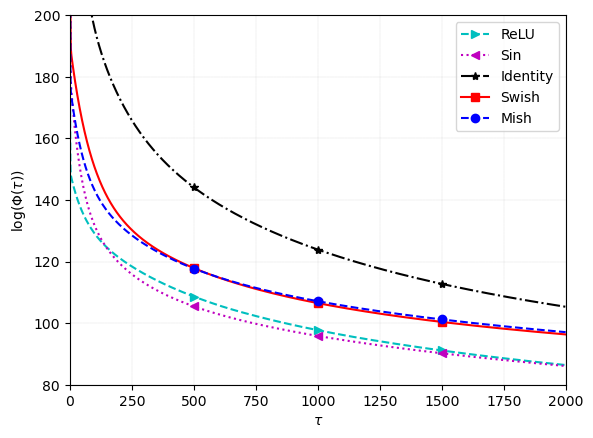

In [251]:
plt.figure(2)
plt.plot(range(epochs), loss_plot3000ReLU,'c--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot3000sin,'m:',marker='<',markevery=500)
plt.plot(range(epochs), loss_plot3000identity,'k-.',marker='*',markevery=500)
plt.plot(range(epochs), loss_plot3000swish,'r-',marker='s',markevery=500)
plt.plot(range(epochs), loss_plot3000mish,'b--',marker='o',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['ReLU','Sin','Identity','Swish','Mish'])
plt.savefig('L2loss_cifar_'+str(width)+'_'+str(Wstd)+'.png')
plt.axis([0,2000,80,200])
plt.savefig('code_DEM_comp_cifar_mod.pdf') 
plt.savefig('code_DEM_comp_cifar_mod.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)